In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

In [31]:
# This function parse the ouput of PerkinElmer 
# Scan Array CSV File to find the start and end 
# of the output table
# It also find the cyanine 5 channel (CH1, CH2 or CH3)
# that contains
# the SH2 domain reading 
def parse_text(start_line='BEGIN DATA', 
               out_file_path=''):
    a=0
    start = 0
    end = 0
    for l in open(out_file_path):
        a+=1
        if l.startswith(start_line):
            start += a
        if l.startswith('END DATA'):
            end += a
        if 'Cyanine 5' in l:
            ch = l.split(',')[1]
            ch = ch.replace('H','h')
    return start, end, ch

NameError: name 'out_file_path' is not defined

In [32]:
out_file_path = os.path.join('data_file_post','811-18_PI3K-P85-NC.csv')
start, end , ch = parse_text(out_file_path=out_file_path)
print(start, end , ch)

72 19274 Ch2


In [33]:
#now we can read an output file
df = pd.read_table(out_file_path, sep=',',
                   skiprows=start, engine ='python', 
                   skipfooter=1)
df.head()

,Index,Array Row,Array Column,Spot Row,Spot Column,Name,ID,X,Y,Diameter,...,Ch2 N Median,Ch2 N Mean,Ch2 N (Median-B),Ch2 N (Mean-B),Ch2 N Ratio of Medians,Ch2 N Ratio of Means,Ch2 N Median of Ratios,Ch2 N Mean of Ratios,Ch2 N Rgn Ratio,Ch2 N Log Ratio
0,1,1,1,1,1,GNEPDKYPCNGQV,>Part3-5146,2307,3401,200,...,3,3,0,0,0.00,0.00,0.00,0.00,0.00,-5.96
1,2,1,1,1,2,NLSQGGYEELERV,>Part3-5151,2539,3382,200,...,4,8,0,4,0.01,0.02,0.01,0.05,0.01,-6.70
2,3,1,1,1,3,ALAAEGYYDIRRV,>Part3-5166,2748,3392,200,...,4,5,0,2,0.02,0.02,0.02,0.03,0.01,-5.91
3,4,1,1,1,4,QHDEPCYWRLTRV,>Part3-5187,2971,3406,200,...,4,4,0,0,0.00,0.00,0.00,0.00,0.00,-5.96
4,5,1,1,1,5,EAGKPIYSRYGSV,>Part3-5199,3200,3384,200,...,3,3,0,0,-0.03,-0.01,0.00,0.00,0.00,-5.96


In [34]:
df.columns

Index(['Index', 'Array Row', 'Array Column', 'Spot Row', 'Spot Column', 'Name',
       'ID', 'X', 'Y', 'Diameter', 'F Pixels', 'B Pixels', 'Footprint',
       'Flags', 'Ch1 Median', 'Ch1 Mean', 'Ch1 SD', 'Ch1 B Median',
       'Ch1 B Mean', 'Ch1 B SD', 'Ch1 % > B + 1 SD', 'Ch1 % > B + 2 SD',
       'Ch1 F % Sat.', 'Ch1 Median - B', 'Ch1 Mean - B',
       'Ch1 SignalNoiseRatio', 'Ch2 Median', 'Ch2 Mean', 'Ch2 SD',
       'Ch2 B Median', 'Ch2 B Mean', 'Ch2 B SD', 'Ch2 % > B + 1 SD',
       'Ch2 % > B + 2 SD', 'Ch2 F % Sat.', 'Ch2 Median - B', 'Ch2 Mean - B',
       'Ch2 SignalNoiseRatio', 'Ch2 Ratio of Medians', 'Ch2 Ratio of Means',
       'Ch2 Median of Ratios', 'Ch2 Mean of Ratios', 'Ch2 Ratios SD',
       'Ch2 Rgn Ratio', 'Ch2 Rgn Rﾲ', 'Ch2 Log Ratio', 'Sum of Medians',
       'Sum of Means', 'Ch1 N Median', 'Ch1 N Mean', 'Ch1 N (Median-B)',
       'Ch1 N (Mean-B)', 'Ch2 N Median', 'Ch2 N Mean', 'Ch2 N (Median-B)',
       'Ch2 N (Mean-B)', 'Ch2 N Ratio of Medians', 'Ch2 N Ratio of Me

In [35]:
res = []
for n in df['ID']:
    try:
        res.append(int(n.split('-')[1].split(' ')[0]))
    except:
        res.append(np.nan)
df['sub_ID'] = res

In [36]:
#df['sub_ID'].value_counts()

# The array is composed of 3 identical blocks 
of 6400 spots, So that each spot on the array is repeated 3 times. The spots contains peptides or a controls (dye, Marker, GST...). A peptide can be spotted multiple times on the same block to control for reproducibility. For example, the peptides RVKEEGYELPYNP and GEEEHVYSFPNKQ are spotted 3 times in different position of the block.

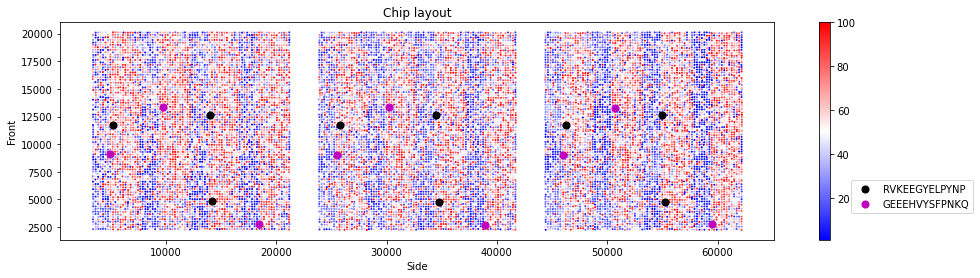

In [48]:
#create percentile of signal - background to color code intensity.
fig,ax=plt.subplots( figsize=(16,4),)
c= pd.qcut(df['Ch2 Mean - B'].rank(method='first'), 100, labels=np.arange(1,101) ).values
df.plot(x='Y', y='X',kind='scatter',s=1,
       c=c, colormap='bwr',ax=ax)

df[df['Name']=='RVKEEGYELPYNP'].plot(x='Y', y='X',
                                     kind='scatter', s=50, c='k',ax=ax,label='RVKEEGYELPYNP')
df[df['Name']=='GEEEHVYSFPNKQ'].plot(x='Y', y='X',
                                     kind='scatter', s=50, c='m',ax=ax,label='GEEEHVYSFPNKQ')


plt.title('Chip layout')
plt.xlabel('Side')
plt.ylabel('Front')
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.2))
plt.show()

# We can also visualize the background
to show experimental artifacts with antibody binding

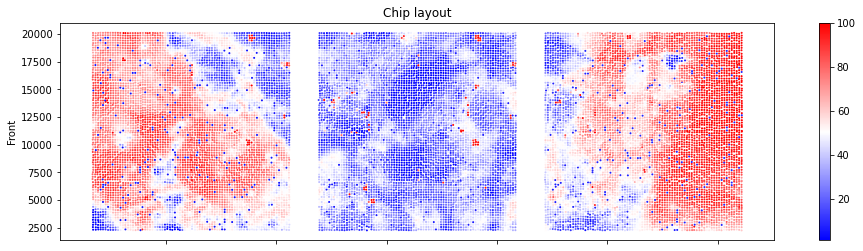

In [49]:
c= pd.qcut(df['Ch2 B Median'].rank(method='first'), 100, labels=np.arange(1,101) ).values
df.plot(x='Y', y='X',kind='scatter', figsize=(16,4), s=1,
       c=c, colormap='bwr')
plt.title('Chip layout')
plt.xlabel('Side')
plt.ylabel('Front')
plt.show()

# A problematic batch
anecdotally identified in the 714 chips, this batch is tagged Part3, with a number id greater than 4000.
This batch is responsible from some stripe patterns in the 714 chips

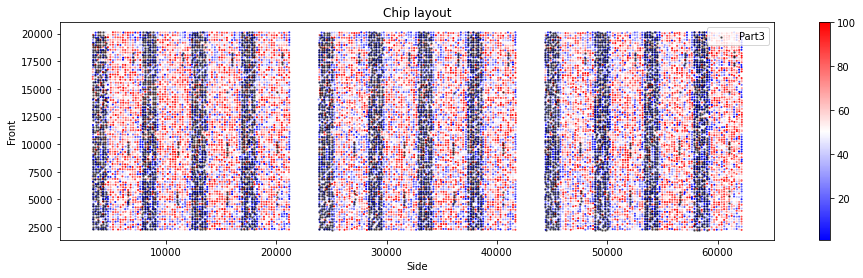

In [10]:
fig,ax=plt.subplots( figsize=(16,4),nrows=1,ncols=1)
c= pd.qcut(df['Ch2 Mean - B'].rank(method='first'), 100, labels=np.arange(1,101) ).values
df.plot(x='Y', y='X',kind='scatter',s=1,
       c=c, colormap='bwr',ax=ax)

df[ df.ID.str.contains('Part3') & (df['sub_ID']>4000)  ].plot(x='Y', y='X',kind='scatter', s=2,
       c='k',alpha=0.5,ax=ax,label='Part3')

plt.title('Chip layout')
plt.xlabel('Side')
plt.ylabel('Front')
plt.legend()
plt.show()

In [11]:
# These are probably the most useful columns
suffixes = [' Median',' Mean',' SD',' B Median',
         ' B Mean',' B SD',' % > B + 1 SD',' % > B + 2 SD',
         ' F % Sat.',' Median - B',' Mean - B',' SignalNoiseRatio']
# to wich we add the peptide sequence and batch identifier
cols = ['Name','ID']+[ch + n for n in suffixes]
df = df[cols]
df.head()

,Name,ID,Ch2 Median,Ch2 Mean,Ch2 SD,Ch2 B Median,Ch2 B Mean,Ch2 B SD,Ch2 % > B + 1 SD,Ch2 % > B + 2 SD,Ch2 F % Sat.,Ch2 Median - B,Ch2 Mean - B,Ch2 SignalNoiseRatio
0,GNEPDKYPCNGQV,>Part3-5146,200,200,44.92,215,215,34.93,15.5,2.8,0,-15,-15,5.78
1,NLSQGGYEELERV,>Part3-5151,472,472,516.95,211,211,32.87,48.2,37.2,0,261,261,7.27
2,ALAAEGYYDIRRV,>Part3-5166,331,331,217.07,209,209,34.19,45.4,32.6,0,122,122,6.99
3,QHDEPCYWRLTRV,>Part3-5187,218,218,33.25,219,219,27.50,15.0,3.1,0,-1,-1,7.93
4,EAGKPIYSRYGSV,>Part3-5199,204,204,39.64,238,238,36.26,4.6,0.4,0,-34,-34,5.71


In [12]:
#some spots contains markers
df['Name'].value_counts().head(10)

<<Marker>>       384
pY                72
IgM               12
TAMRA             12
GST               12
FITC              12
Triple Flaq       12
IgG               12
FLPVPEYINQSVP      9
GTAEPDYGALYEG      9
Name: Name, dtype: int64

In [13]:
# the peptides in the array where sintetised in
# different batches
df['batch']=[n.split('-')[0] for n in df['ID']]
df.groupby('batch').size()

batch
5198_1       72
5804_1       12
5804_2       12
>Jerini     753
>Part1      492
>Part2      804
>Part3     9273
SH2          12
none       7770
dtype: int64

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()
import logomaker as lm

# Compariso Chip signal - pepSpot db

## SignalNoiseRatio

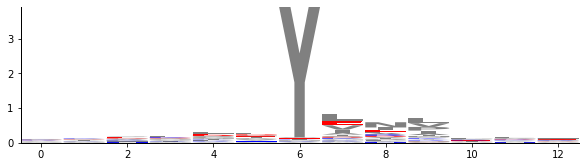

In [113]:
# The processing of the data is arbitray. I can suggest:
# Median of signal using the peptide sequences
# filter for 'Ch1 Median - B' > 0
temp = df.groupby('Name')['Ch2 SignalNoiseRatio'].median().sort_values(ascending = False)
#get the top 500  
seqs = [n for n in list(temp.head(500).index.values) if len(n)==13 and 'Z' not in n]
# create counts matrix
'''
to_type: (str)
The type of matrix to output. Must be 'counts', 'probability',
'weight', or 'information'
'''
ww_counts_df = lm.alignment_to_matrix(sequences=seqs, 
                                      to_type='information',)
crp_logo=lm.Logo(ww_counts_df,color_scheme='charge')
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
#plt.ylim(0,10)
plt.show()

/Users/MTinti/miniconda3/envs/myEnv/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


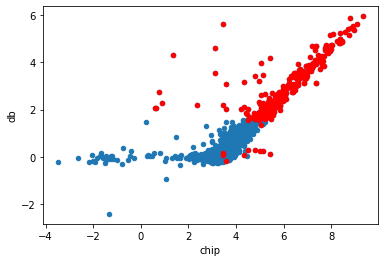

In [120]:
slide_data = df.groupby('Name')['Ch2 SignalNoiseRatio'].median().sort_values(ascending = False)
slide_data=slide_data.to_frame()

db_data = pd.read_csv('SH2_all_logratio_values.csv',sep='\t')
db_data=db_data[['sequence','SH2_PI3K_P85_N_C_18-01-2007__811-18']]
db_data.set_index('sequence',inplace=True)



db_binders = pd.read_csv('SH2_all_logratio_binders.csv',sep='\t')
db_binders=db_binders[['sequence','SH2_PI3K_P85_N_C_18-01-2007__811-18']]
db_binders=db_binders[db_binders['SH2_PI3K_P85_N_C_18-01-2007__811-18']==2]
db_binders=list(db_binders['sequence'])


merge = slide_data.join(db_data)
merge.columns = ['chip','db']
merge['chip']=np.log2(merge['chip'])
fig,ax=plt.subplots()
merge.plot(kind='scatter',x='chip',y='db',ax=ax)
merge.loc[db_binders].plot(kind='scatter',x='chip',y='db',c='r',ax=ax)
plt.show()

##  Median - B

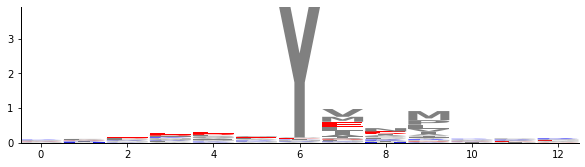

In [116]:
# The processing of the data is arbitray. I can suggest:
# Median of signal using the peptide sequences
# filter for 'Ch1 Median - B' > 0
temp = df.groupby('Name')['Ch2 Median - B'].median().sort_values(ascending = False)
#get the top 500  
seqs = [n for n in list(temp.head(500).index.values) if len(n)==13 and 'Z' not in n]
# create counts matrix
'''
to_type: (str)
The type of matrix to output. Must be 'counts', 'probability',
'weight', or 'information'
'''
ww_counts_df = lm.alignment_to_matrix(sequences=seqs, 
                                      to_type='information',)
crp_logo=lm.Logo(ww_counts_df,color_scheme='charge')
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
#plt.ylim(0,10)
plt.show()

/Users/MTinti/miniconda3/envs/myEnv/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log2
/Users/MTinti/miniconda3/envs/myEnv/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log2
/Users/MTinti/miniconda3/envs/myEnv/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


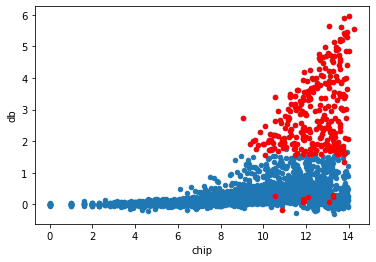

In [121]:
slide_data = df.groupby('Name')['Ch2 Median - B'].median().sort_values(ascending = False)
slide_data=slide_data.to_frame()

db_data = pd.read_csv('SH2_all_logratio_values.csv',sep='\t')
db_data=db_data[['sequence','SH2_PI3K_P85_N_C_18-01-2007__811-18']]
db_data.set_index('sequence',inplace=True)
db_data.head()







merge = slide_data.join(db_data)
merge.columns = ['chip','db']
merge['chip']=np.log2(merge['chip'])


fig,ax=plt.subplots()
merge.plot(kind='scatter',x='chip',y='db',ax=ax)
merge.loc[db_binders].plot(kind='scatter',x='chip',y='db',c='r',ax=ax)
plt.show()


In [115]:
# The raw files starting with different 
# nubers have a different layout of the 
# blocks: 816 and 811 have same layout that differs from 714
fnames = []
for fname in os.listdir('data_file_post'):
    if fname.endswith('csv'):
        fnames.append(fname.split('-')[0])
print(set(fnames))

{'816', '811', '714'}
